In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F

import logging

%matplotlib inline
sns.set(color_codes=True)

In [44]:
# import wandb
# wandb.login()

In [45]:
df_train = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)
df_train.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
df_train = df_train.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)
display(df_train.head())

df_test = pd.read_csv('../input/sentiment-test/testdata_manual_2009_06_14.csv', encoding='latin-1', header = None)
df_test.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
df_test = df_test.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)
display(df_test.head())

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


,Sentiment,Tweet
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


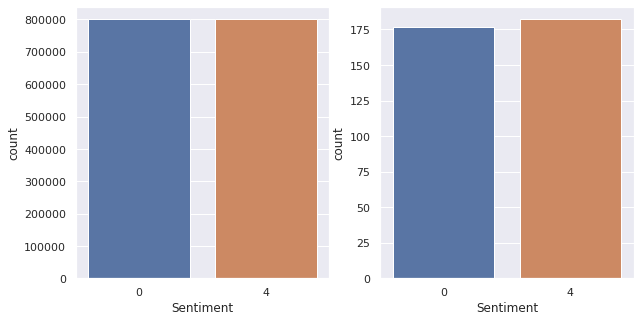

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(df_train.Sentiment, ax=ax[0])
sns.countplot(df_test.Sentiment, ax=ax[1])
plt.show()

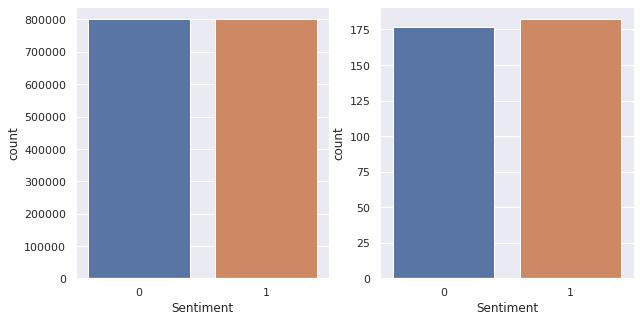

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df_train['Sentiment'] = df_train.Sentiment.replace(4,1)
sns.countplot(df_train.Sentiment, ax=ax[0])

df_test['Sentiment'] = df_test.Sentiment.replace(4,1)
sns.countplot(df_test.Sentiment,ax=ax[1])

In [48]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [49]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
#     text= cleaning_stopwords(text)
    texttest = re.sub(r'http\S+', '', text)    #将所有以'http'开头的字符串替换为空字符串。
    text = hashtags.sub(' hashtag', text)  #将文本中的所有hashtag（即以#开头的话题标签）替换为字符串'hashtag'。
    text = mentions.sub(' entity', text)   #将文本中的所有mention（即以@开头的用户提及）替换为字符串'entity'。
    return text.strip().lower()            #删除文本中的首尾空白字符，并将文本转换为小写字母。

In [50]:
df_train['Tweet'] = df_train.Tweet.apply(process_text)
display(df_train.head())

df_test['Tweet'] = df_test.Tweet.apply(process_text)
display(df_test.head())

,Sentiment,Tweet
0,0,"entity http://twitpic.com/2y1zl - awww, that's..."
1,0,is upset that he can't update his facebook by ...
2,0,entity i dived many times for the ball. manage...
3,0,my whole body feels itchy and like its on fire
4,0,"entity no, it's not behaving at all. i'm mad. ..."


,Sentiment,Tweet
0,1,entity i loooooooovvvvvveee my kindle2. not th...
1,1,reading my kindle2... love it... lee childs i...
2,1,"ok, first assesment of the hashtag ...it fucki..."
3,1,entity you'll love your kindle2. i've had mine...
4,1,entity fair enough. but i have the kindle2 an...


In [51]:
df_train = df_train.sample(500, random_state=1)     #不适用所有数据，而是随机抽取的一定样本数加快时间
labels_train = df_train.Sentiment.values
text_train = df_train.Tweet.values

labels_test = df_test.Sentiment.values
text_test = df_test.Tweet.values

In [52]:
from transformers import BertTokenizer,BertForSequenceClassification,AdamW
tokenizer = BertTokenizer.from_pretrained('textattack/bert-base-uncased-SST-2',do_lower_case = True)

In [53]:
def three_part(text,labels):
    input_ids = []
    attention_mask = []
    for i in text:
        encoded_data = tokenizer.encode_plus(
                i,
                add_special_tokens=True,
                max_length=64,
                pad_to_max_length = True,
                return_attention_mask= True,
                return_tensors='pt')
        input_ids.append(encoded_data['input_ids'])
        attention_mask.append(encoded_data['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0)
    attention_mask = torch.cat(attention_mask,dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_mask, labels

input_ids_train, attention_mask_train, labels_train=three_part(text_train,labels_train)
input_ids_test, attention_mask_test, labels_test=three_part(text_test,labels_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [54]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

# dataset = TensorDataset(input_ids,attention_mask,labels_train)
# train_size = int(0.8*len(dataset))
# val_size = len(dataset) - train_size
# train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

train_dataset = TensorDataset(input_ids_train, attention_mask_train, labels_train)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, labels_test)

print('Training Size - ',len(train_dataset))
print('Testing Size - ',len(test_dataset))

Training Size -  500
Testing Size -  359


In [55]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 32)
# val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
#                      batch_size = 32)

test_dl = DataLoader(test_dataset,sampler = SequentialSampler(test_dataset),
                     batch_size = 32)
len(train_dl),len(test_dl)

(16, 12)

In [56]:
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels = 2,output_attentions = False,output_hidden_states = False)
# model = BertForSequenceClassification.from_pretrained('google/bert_uncased_L-2_H-768_A-12',num_labels = 2,output_attentions = False,output_hidden_states = False)
# model = BertForSequenceClassification.from_pretrained('bert-large-uncased',num_labels = 2,output_attentions = False,output_hidden_states = False)
# model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels = 2,output_attentions = False,output_hidden_states = False)
# model = BertForSequenceClassification.from_pretrained('bert-large-uncased-whole-word-masking',num_labels = 2,output_attentions = False,output_hidden_states = False)
model = BertForSequenceClassification.from_pretrained('textattack/bert-base-uncased-SST-2',num_labels = 2,output_attentions = False,output_hidden_states = False)

In [57]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8)

In [58]:
from transformers import get_linear_schedule_with_warmup
epochs = 10
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [59]:
def accuracy(preds,labels):    #准确率函数定义
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

def evaluate(dataloader_test):   #评估函数
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [60]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
# 初始化记录损失的列表
train_losses = []
test_losses = []
test_acces=[]
batches=[]
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        batch1=[]
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
#         batch1.append('{:.3f}'.format(loss.item()/len(batch)))
    
    batches.append(batch1)
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dl)
    train_losses.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')

    test_loss, predictions, true_tests = evaluate(test_dl)
    test_losses.append(test_loss)
    test_acc = accuracy(predictions, true_tests)
    test_acces.append(test_acc)
    tqdm.write(f'Testing loss: {test_loss}')
    tqdm.write(f'Accuracy: {test_acc}')



Epoch 1
Training loss: 0.6106016542762518
Testing loss: 0.3868523749212424
Accuracy: 0.8467966573816156



Epoch 2
Training loss: 0.29333989135921
Testing loss: 0.4187501979370912
Accuracy: 0.8495821727019499



Epoch 3
Training loss: 0.1476288066478446
Testing loss: 0.47145363067587215
Accuracy: 0.8690807799442897



Epoch 4
Training loss: 0.0612796320929192
Testing loss: 0.5742469678322474
Accuracy: 0.8523676880222841



Epoch 5
Training loss: 0.023224200689583085
Testing loss: 0.6223769759138426
Accuracy: 0.8551532033426184



Epoch 6
Training loss: 0.008745275845285505
Testing loss: 0.7036898794273535
Accuracy: 0.8551532033426184



Epoch 7
Training loss: 0.007175999126047827
Testing loss: 0.715893104672432
Accuracy: 0.8607242339832869



Epoch 8
Training loss: 0.009839476457273122
Testing loss: 0.7186030335724354
Accuracy: 0.8607242339832869



Epoch 9
Training loss: 0.005435862272861414
Testing loss: 0.7239188005526861
Accuracy: 0.8635097493036211



Epoch 10
Training loss: 0.006639987506787293
Testing loss: 0.7260629273951054
Accuracy: 0.8607242339832869



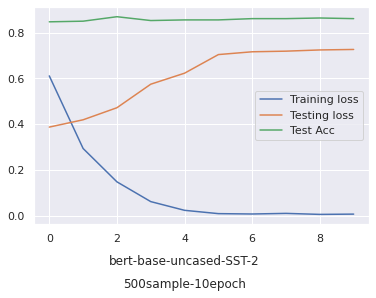

In [68]:
# 绘制训练和测试损失的变化情况
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.plot(test_acces, label='Test Acc')
plt.text(4, -0.2, "bert-base-uncased-SST-2", ha='center', va='center')
plt.text(4, -0.3, "500sample-10epoch", ha='center', va='center')
plt.legend()
plt.savefig('bert-base-uncased-SST-2_0.869.png', bbox_inches='tight')
plt.show()

In [62]:
# output_dir = './'
# model_to_save = model.module if hasattr(model, 'module') else model
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

In [63]:
from transformers import BertTokenizer,BertForSequenceClassification
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [66]:
#错误分析
# decode_map = {0: "NEGATIVE", 1: "POSITIVE"}
# def decode_sentiment(label):
#     return decode_map[int(label)]

# df = pd.DataFrame(test.text, columns=["text"])
# df['ids'] = test.ids
# df["actual"] = test.target
# df["predicted"] = predicted_tweets_binary
# df.predicted = df.predicted.apply(lambda x: decode_sentiment(x))
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', None)
# incorrect = df[df["actual"] != df["predicted"]]
# incorrect[10:20]

In [67]:
# correct = df[df['actual'] == df['predicted']]
# correct.head(10)